In [12]:
import torch
from torch import nn

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from pathlib import  Path

In [21]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


In [32]:
# y = sin(x) + 0.5x^2 − 3
def f(x):
    return torch.sin(x) + 0.5 * x**2 - 3

start = -10
stop = 10
step = 0.1

X = torch.arange(start, stop, step).unsqueeze(-1)
y = f(X)

X.shape, y.shape, len(X), len(y)

(torch.Size([200, 1]), torch.Size([200, 1]), 200, 200)

In [33]:
split = 0.8

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=255)
len(X_train), len(X_test), len(y_train), len(y_test)

(160, 40, 160, 40)

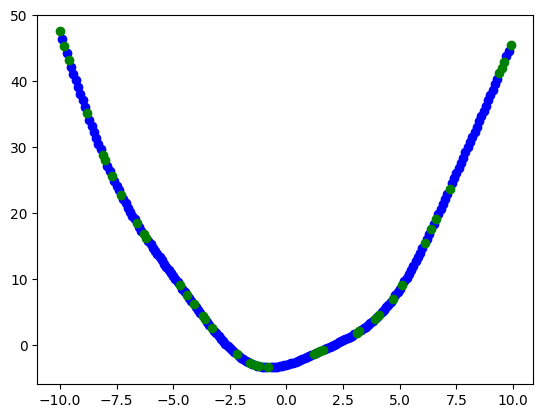

In [36]:
plt.scatter(X_train, y_train, color='blue',)
plt.scatter(X_test, y_test, color='green',)

In [19]:
class LinearReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [39]:
def save_state(save_path: Path, model: nn.Module, optim: torch.optim.Optimizer, epoch):
    model_state_dict = model.state_dict()
    optim_state_dict = optim.state_dict()
    
    state_dict = {
        'epoch': epoch,
        'model_state' : model_state_dict,
        'optim_state' : optim_state_dict,
    }
    torch.save(state_dict, save_path)
    print('Model state saved.')

In [72]:
model = LinearReg().to(device)
model

LinearReg(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [73]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [74]:
num_epochs = 3000

epochs_list = []
train_losses = []
val_losses = []

model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)
save_path = model_dir / 'state.pth'

for epoch in range(num_epochs):
    model.train()
    y_pred = model(X_train.to(device))
    
    loss = loss_fn(y_pred, y_train.to(device))
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    
    model.eval()
    
    with torch.inference_mode():
        y_pred = model(X_test.to(device))
        val_loss = loss_fn(y_pred, y_test.to(device))
    
    if epoch % 100 == 0:
        epochs_list.append(epoch)
        train_losses.append(loss.cpu().detach().numpy())
        val_losses.append(val_loss.cpu().detach().numpy())
        
        print(f'Epoch {epoch}/{num_epochs}:\tTrain Loss: {loss:0.4f}\tVal Loss: {val_loss:0.4f}')
        if(val_loss.cpu().numpy() == np.min(val_losses)):
            save_state(save_path, model, optim, epoch)

Epoch 0/3000:	Train Loss: 374.0302	Val Loss: 495.0823
Model state saved.
Epoch 100/3000:	Train Loss: 133.0027	Val Loss: 195.7293
Model state saved.
Epoch 200/3000:	Train Loss: 36.2756	Val Loss: 52.5056
Model state saved.
Epoch 300/3000:	Train Loss: 20.8110	Val Loss: 31.0349
Model state saved.
Epoch 400/3000:	Train Loss: 13.4150	Val Loss: 19.7368
Model state saved.
Epoch 500/3000:	Train Loss: 10.0657	Val Loss: 14.6875
Model state saved.
Epoch 600/3000:	Train Loss: 8.4163	Val Loss: 12.7665
Model state saved.
Epoch 700/3000:	Train Loss: 6.9598	Val Loss: 11.0259
Model state saved.
Epoch 800/3000:	Train Loss: 5.6100	Val Loss: 9.2603
Model state saved.
Epoch 900/3000:	Train Loss: 4.3673	Val Loss: 7.5564
Model state saved.
Epoch 1000/3000:	Train Loss: 3.2784	Val Loss: 5.9941
Model state saved.
Epoch 1100/3000:	Train Loss: 2.3901	Val Loss: 4.6878
Model state saved.
Epoch 1200/3000:	Train Loss: 1.7137	Val Loss: 3.6236
Model state saved.
Epoch 1300/3000:	Train Loss: 1.2289	Val Loss: 2.7933
Model

In [75]:
def predict(model, X_test):
    model.eval()

    with torch.inference_mode():
        preds = model(X_test.to(device))
    preds = preds.cpu()
    return preds


preds = predict(model, X_test)

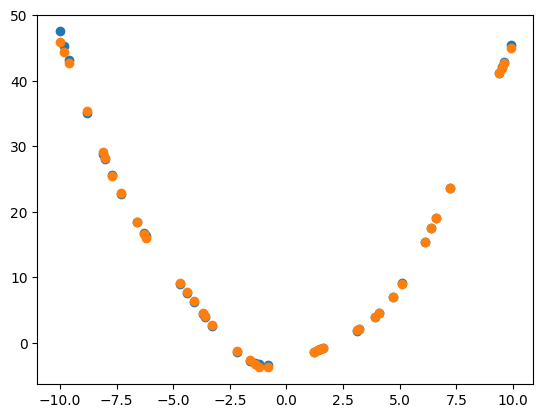

In [76]:
plt.scatter(X_test, y_test)
plt.scatter(X_test, preds)

In [62]:
model1 = LinearReg()

state_dicts = torch.load(save_path)
state_dicts.keys()

dict_keys(['epoch', 'model_state', 'optim_state'])

In [68]:
model1.load_state_dict(state_dicts['model_state'])

<All keys matched successfully>

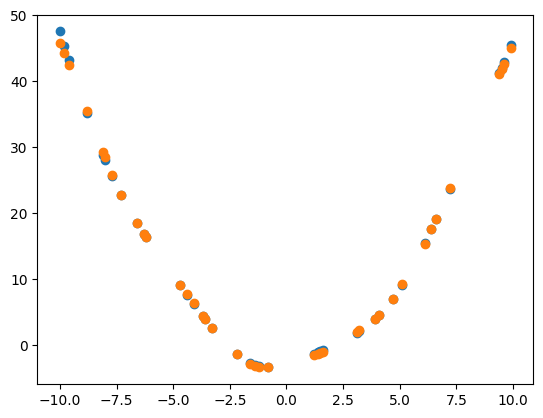

In [ ]:
preds1 = predict(model1.to(device), X_test)

plt.scatter(X_test, y_test)
plt.scatter(X_test, preds1)